In [91]:
#Helper libraries
import pandas as pd
import numpy as np
import random
import json
import networkx as nx

# Text processing
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Embedding libraries
from karateclub.utils.walker import RandomWalker
from karateclub import DeepWalk
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

#Data visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#Matrix dimension reduction
from sklearn.decomposition import PCA

#Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Vectorization of Online Social Networks for Machine Learning

### Introduction

There is an abundance of non-numerical data that we would like to learn more about, but that computers cannot understand. Data such as text and graphs are nonsensical to computers, who specialize in processing numerical data. Their numerical representation in memory loses all meaning and context to the data. Fortunately, there is a way to translate text and graphs into numbers while preserving the essence of the data. This process is called embedding.


### What are embeddings?
Machine Learning algorithms depend on many linear algebra concepts to function as they do; finding angles, projection, scalar multiplication and much more. As such, they require data that lives on a vector space as input to function as intended. Unfortunately, there is a plethora of very useful data that is not naturally represented as a vector space. Let's use text as an example, I cannot multiply the word "justice" by a scalar of 3 to get three times the amount of "justice". I cannot calculate "King + Woman - Man" to get the word "Queen". If only there was a way to map words to vectors while somehow preserving their context and meaning.

Fortunately, there are techniques that allow us to translate non-vectorized data into a vector space. Such techniques create embeddings from data. Once we have an embedding, we can apply Machine Learning algorithms to discover insights.


### Word embedding example
Let's form a better understanding of embeddings with an example using words. Here is the word "King" vectorized from trained on a dataset of Wikipedia sentences: 

In [106]:
model['king']

array([ 1.359663  , -0.8382059 , -0.84660816, -1.558449  ,  4.7252    ,
        0.13881727, -1.4921931 , -1.8130385 ,  0.0511693 ,  0.85508645,
        6.5785184 ,  2.7810016 ,  1.667084  ,  2.7194495 , -0.4396203 ,
        2.7486732 ,  1.1177679 ,  0.7349494 ,  0.24423797,  1.2825176 ,
        1.2005143 , -0.03846038, -0.6542252 , -2.5649042 , -1.8963375 ,
        3.3950014 ,  4.9965744 , -4.1288104 , -4.561981  ,  0.26342165,
        1.997457  ,  0.5563056 , -4.13742   ,  0.6028524 ,  3.9190137 ,
       -0.84424156,  0.35301694, -2.7149537 , -0.20672867, -1.0115309 ,
        3.1524494 ,  1.544902  , -0.08085205, -1.4855855 ,  1.4157073 ,
       -1.971465  ,  2.2682142 , -2.9461362 , -1.930372  ,  0.63356024],
      dtype=float32)

Nonsensical to humans, but let's color code the values of each dimension.

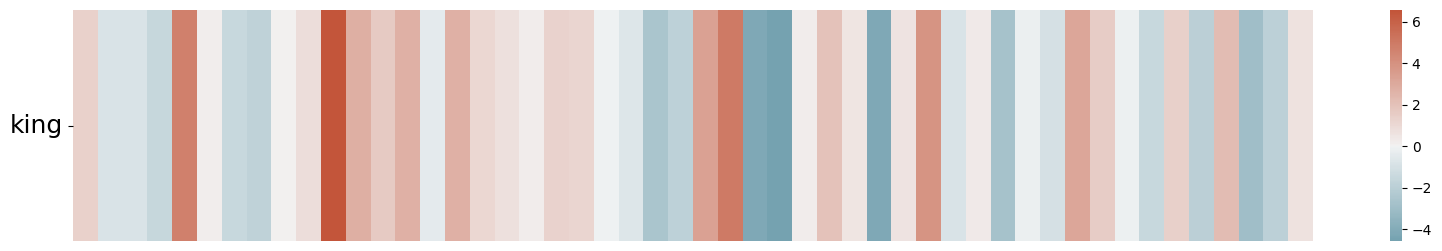

In [135]:
df = pd.DataFrame([model['king']])

plt.figure(figsize=(20,3))
ax = sns.heatmap([model['king']], fmt="g",cmap=cmap, xticklabels=False, yticklabels=['king'], center=0)
ax.tick_params(axis='y', rotation=0, labelsize=18)

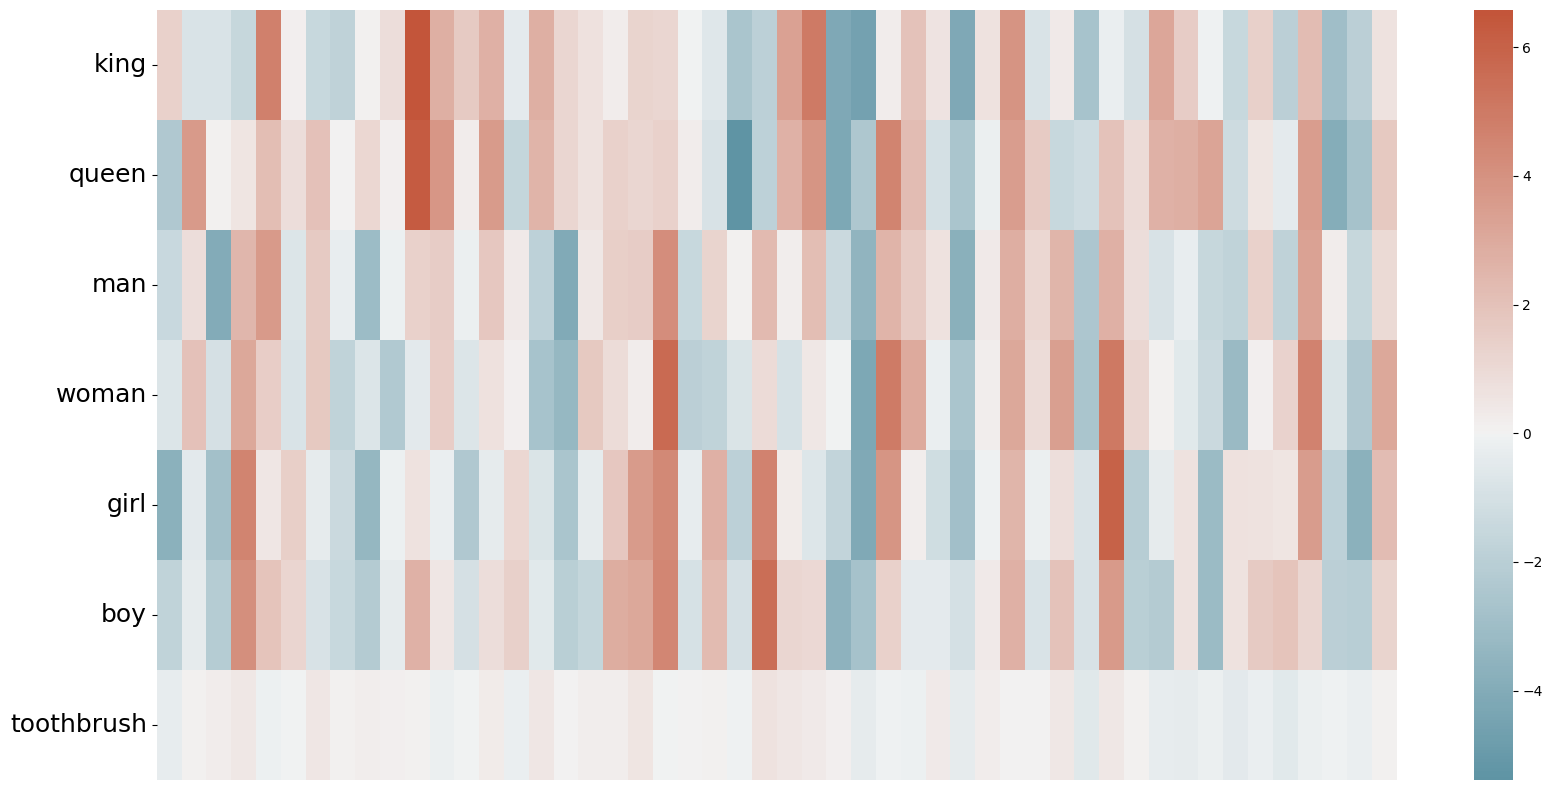

In [136]:
words = ['king', 'queen', 'man', 'woman', 'girl', 'boy', 'toothbrush']
word_vectors = [model[word] for word in words]
df = pd.DataFrame(word_vectors)

cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(20,10)) 
ax = sns.heatmap(df, fmt="g",cmap=cmap, xticklabels=False, yticklabels=words, center=0)
ax.tick_params(axis='y', rotation=0, labelsize=18)

A cursory look at this shows some patterns. Some words have very similar dimensions in some areas but not others. For example,  King and Queen have the same few blue bars clustered. These dimensions might vaguely resemble the concept of royalty.

Let's try some vector arithmetic. Here is a famous result of "King + Woman - Man = Queen"

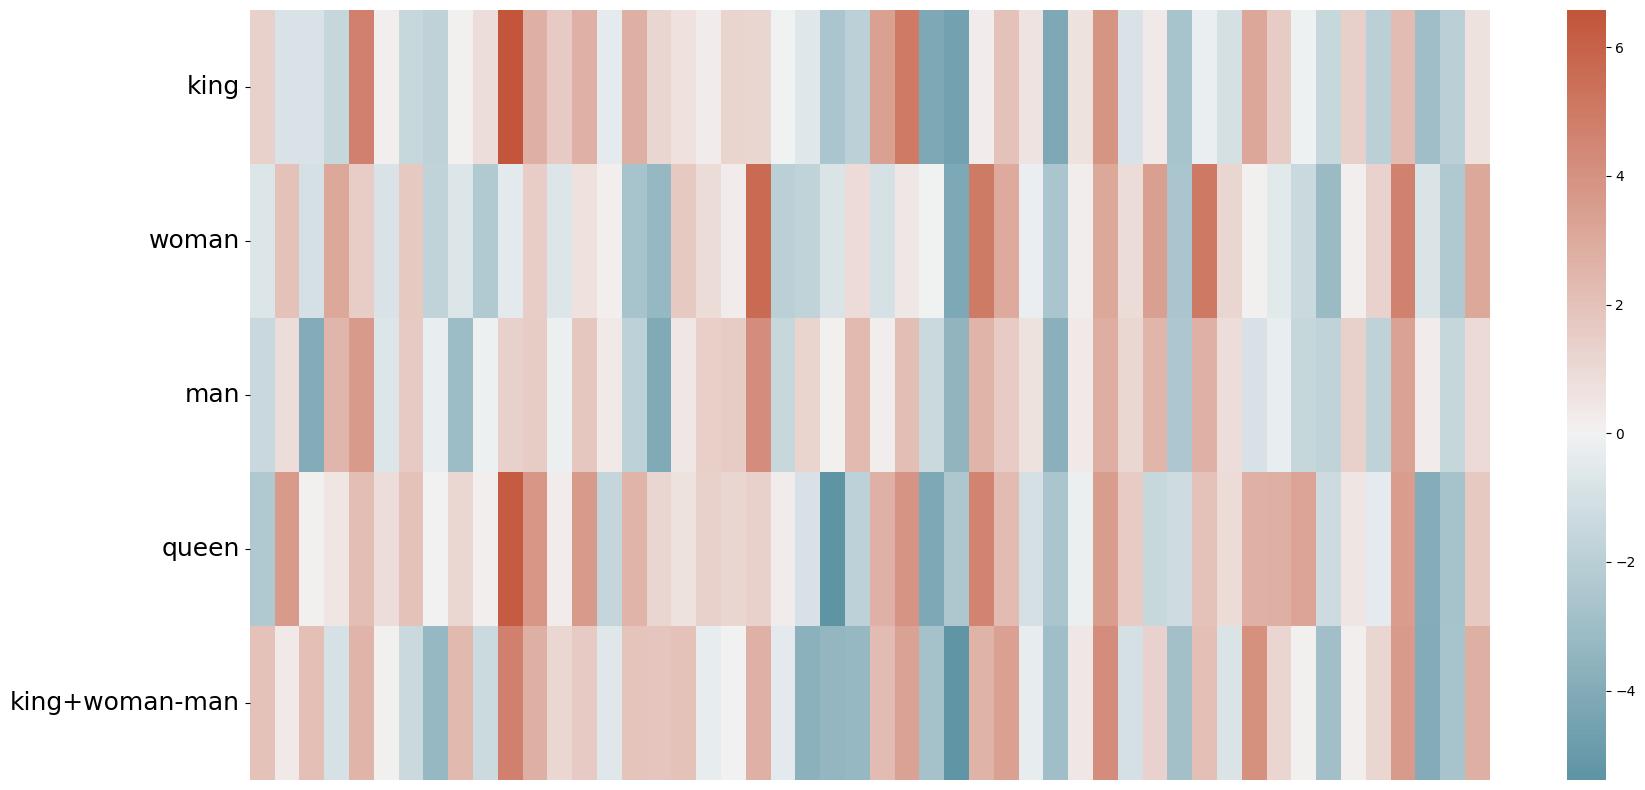

In [150]:
result_vector = model['king'] + model['woman'] - model['man']
word_vectors = [model['king'], model['woman'], model['man'], model['queen'], result_vector]
words = ['king', 'woman', 'man', 'queen', 'king+woman-man']
df = pd.DataFrame(word_vectors)

cmap = sns.diverging_palette(220, 20, as_cmap=True)
plt.figure(figsize=(20,10)) 
ax = sns.heatmap(df, fmt="g",cmap=cmap, xticklabels=False, yticklabels=words, center=0)
ax.tick_params(axis='y', rotation=0, labelsize=18)

The resulting vector is very similar to the queen vector.

## What is Word2Vec?

Word2Vec is a collection of algorithms and model architectures that can be used to learn word embeddings from large datasets. It takes input of a text corpus and outputs a vector space of typically several hundred dimensions, with each unique word mapped to a vector in the space. Words with similar contexts share vectors in close proximity to one another. We measure "close proximity" with cosine similarity.

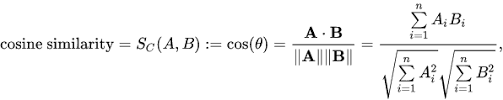

#### Continuous Bag Of Words and Skip-Gram
There are two algorithms in which you can train Word2Vec: Continuous Bag Of Words (CBOW) or Skip-Gram. CBOW attempts to predict a word given the words that surround it. Inversely, Skip-Gram takes a word attempts to predict the words arround it. For example, given the words "The Quick ___ Fox Jumped", CBOW will predict "Brown". Given the word "Brown", Skip-Gram will predict 'The', 'Quick', 'Fox' and "Jumped". 
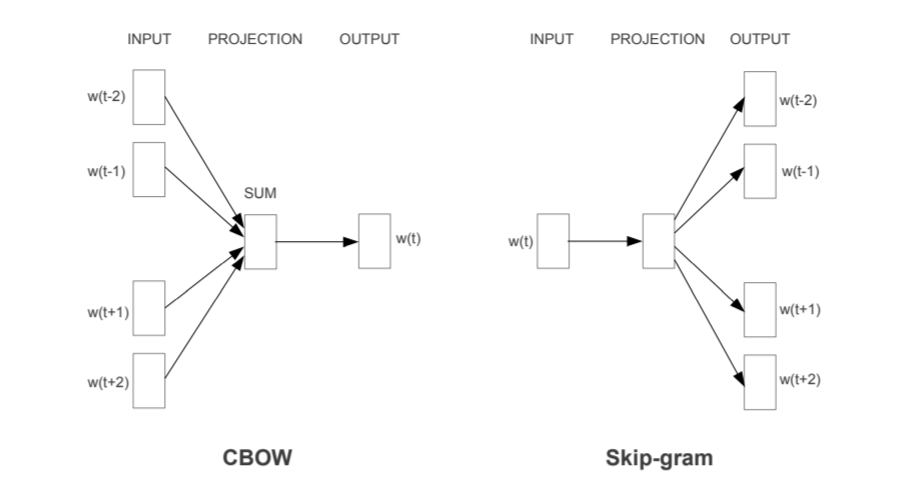

## Word embeddings with Word2Vec using sentences from Wikipedia.
We will be using sentences from Wikipedia as our text corpus. It contains a collection of 7.8 million sentences from the August 2018 English Wikipedia dump. You can find the dataset here: https://www.kaggle.com/mikeortman/wikipedia-sentences

Here we tokenize the data and clean all punctuation and stop words(e.g. 'the', 'is', 'that', etc) from the data set. Then we train the model. We need to do this because Word2Vec only accepts lists of tokenized sentences, with the added bonus of also filtering useless contextual words. 

Note that this process takes roughly 15 minutes.

In [60]:
filepath = 'data/wikisent2.txt'
filteredWords = set(stopwords.words('english') + list(string.punctuation))

#Read the dataset and populate the sentences list with tokenized sentences. 
sentences = []
with open(filepath) as fp:
    line = fp.readline()
    while line:
        wordTokens = word_tokenize(line)
        filtered_sentence = [w.lower() for w in wordTokens if not w.lower() in filteredWords]
        sentences.append(filtered_sentence)
        line = fp.readline()
        
#Create the model.
model = Word2Vec(sentences=sentences, vector_size=50, window=5, min_count=5, workers=10)

#Save model for future use.
model.wv.save_word2vec_format('models/wikisent2_50.bin', binary=True)

In [62]:
#Load the previously created model.
model = KeyedVectors.load_word2vec_format('models/wikisent2_50.bin', binary=True)

Let's test out our model by finding words used in similar context. 

In [64]:
model.most_similar('economy')[:5]

[('economic', 0.8690537214279175),
 ('economies', 0.8402500152587891),
 ('industrialization', 0.7944962978363037),
 ('self-sufficiency', 0.7845162749290466),
 ('industrialisation', 0.7487539649009705)]

In [65]:
model.most_similar('garlic')[:5]

[('onions', 0.9568761587142944),
 ('walnuts', 0.9503108859062195),
 ('almonds', 0.949909508228302),
 ('celery', 0.9447917342185974),
 ('carrots', 0.9432381987571716)]

In [66]:
model.most_similar('university')[:5]

[('college', 0.8338056206703186),
 ('institute', 0.7638230919837952),
 ('graduate', 0.7173405289649963),
 ('faculty', 0.7088996767997742),
 ('polytechnic', 0.696407675743103)]

In [67]:
model.most_similar('honor')[:5]

[('valor', 0.700442910194397),
 ('courage', 0.6898362636566162),
 ('honors', 0.6742855310440063),
 ('bravery', 0.6635182499885559),
 ('heroism', 0.6538971662521362)]

## Word and context similarity

Word2Vec is able to quantify context and word similarity. Patterns such as “Man is to King as Woman is to Queen” can be obtained through vector arithmetic of the word vectors. We can show these analagous relationships in other contexts such as country/capital or past-present verb tenses. Below are a few examples of this in action

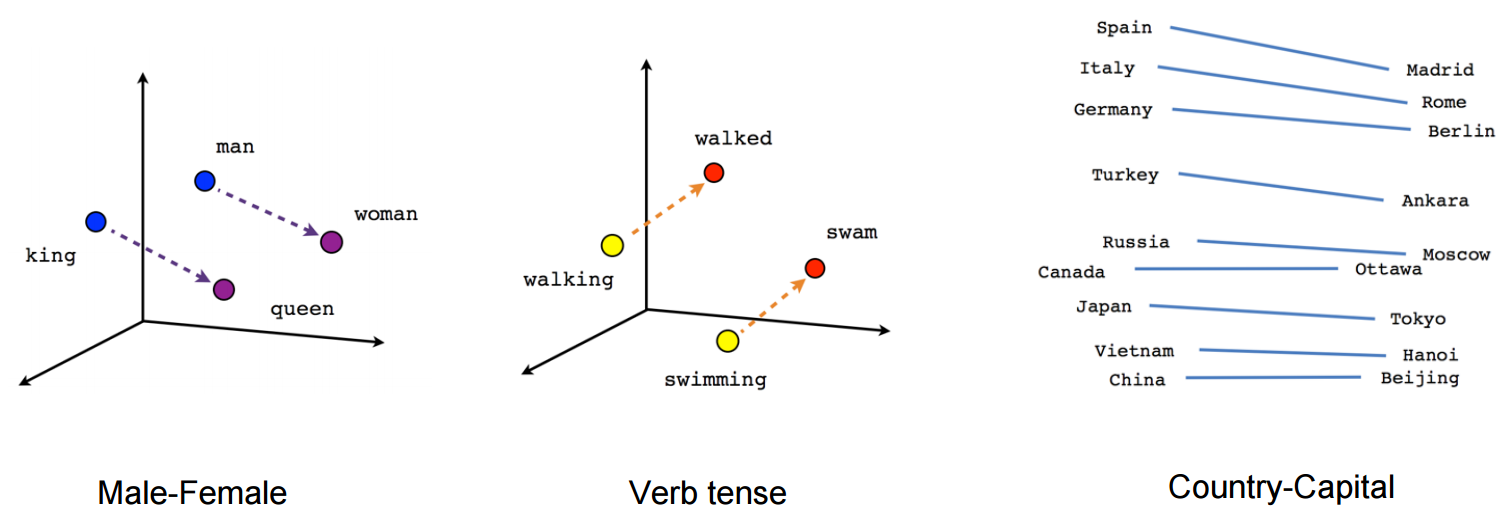

In [68]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [69]:
analogy('japan', 'japanese', 'australia')

'australian'

In [70]:
analogy('walked', 'walking', 'swam')

'swimming'

In [71]:
analogy('september', 'fall', 'april')

'spring'

In [72]:
analogy('boy', 'prince', 'girl')

'princess'

In [73]:
analogy('tall', 'tallest', 'long')

'longest'

In [77]:
analogy('berlin', 'germany', 'paris')

'france'

In [75]:
analogy('man', 'king', 'woman')

'queen'

In [76]:
print(model.doesnt_match(["breakfast", "lunch", "dinner", "study"]))

study


## Visualization of Embeddings
Our word embeddings have a dimension of 100, but we can apply Principal Component Analysis (PCA) to reduce the dimensionality to two so that we may create visualizations in two-dimensional space.

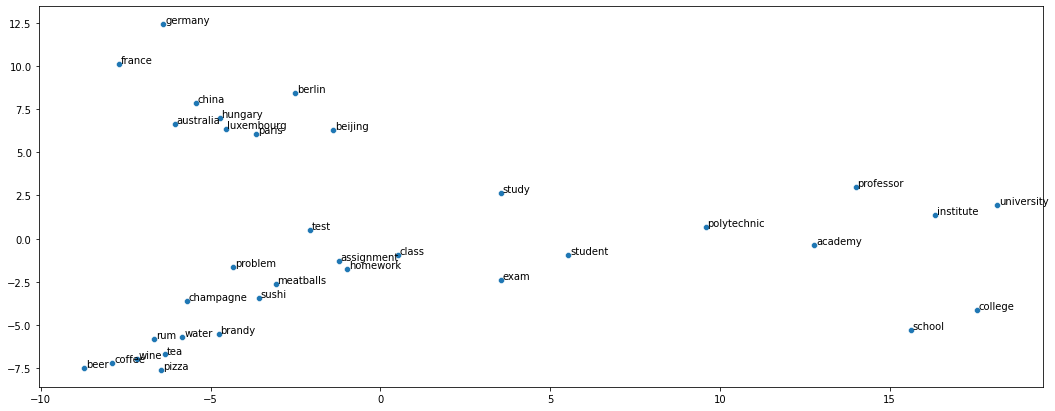

In [53]:
words = ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water', 
          'pizza',  'sushi', 'meatballs',
         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'china', 'berlin', 'beijing', 'paris',
         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
         'school', 'college', 'university', 'institute', 'academy', 'polytechnic', 'student', 'professor', 'study'
        ]

wordVectors = [model[w] for w in words]
twoDim = PCA().fit_transform(wordVectors)[:,:2]
plot = sns.scatterplot(x = twoDim[:, 0], y = twoDim[:, 1])
for word, (x,y) in zip(words, twoDim):
    plot.text(x+.05, y+.05, str(word))

### Why is Word2Vec useful?
Some obvious applications of Word2Vec is the text prediction functionality within your phone alongside code prediction in some IDEs. More creatively, Word2Vec can be extended beyond text sentences. It can be applied to social media graphs, genes, music playlists and much more. This is because words are discrete states much like the aforementioned data and we are simply looking for the probabilities that one state will turn into another. 


Given enough data, Word2vec can make highly accurate guesses about a word’s meaning. Those guesses can be used to create word associations and create clusters of words with similar meaning. These clusters can form the basis of search, sentiment analysis and recommendation systems that are useful for scientific research, legal teams, streaming services and social media. Your creativity is the limit.

# Graph Embeddings with Deep Walk

TBD

## Classifying graphs using DeepWalk

### Karate Club Example
We are going to use famous Zachary's karate club dataset which comes with `NetworkX` package and `karateclub`'s implementation of the DeepWalk algorithm. Each student in the graph belongs to 1 of the 2 karate clubs - Officer or Mr. Hi. 

In [40]:
G = nx.karate_club_graph()  # load data

clubs = []  # list to populate with labels
for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)

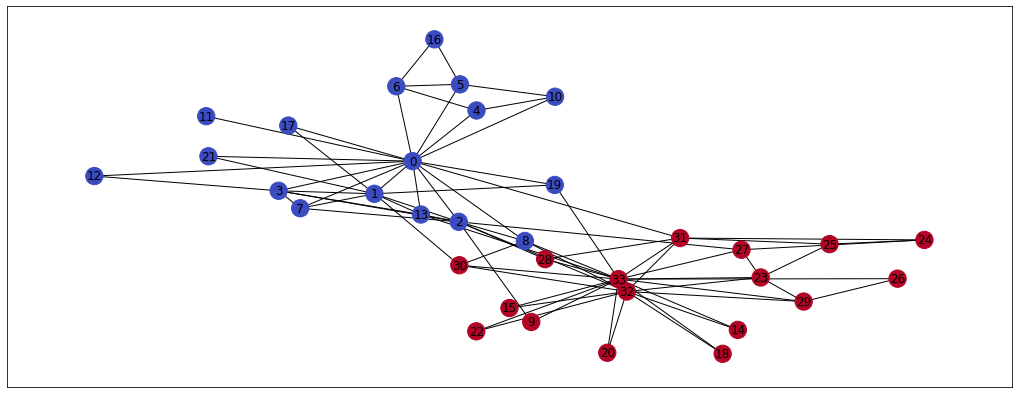

In [41]:
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph

As you can see, members of the karate clubs talk mainly to their club members. This information could be very valuable for e.g. classification or community detection tasks and we can represent it using the node embeddings.

In [42]:
model = DeepWalk(dimensions=124)  # node embedding algorithm
model.fit(G)  # fit it on the graph
embedding = model.get_embedding()  # extract embeddings

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


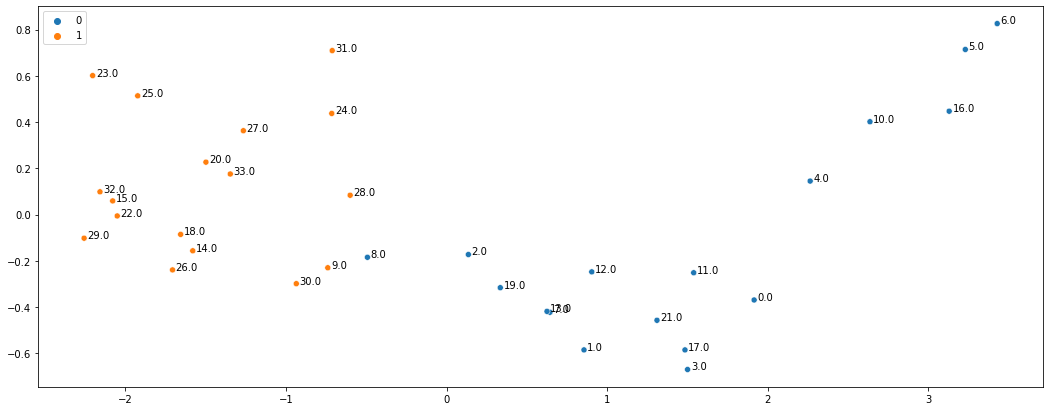

In [43]:
twoDim = PCA().fit_transform(embedding)

plot = sns.scatterplot(x = twoDim[:, 0], y = twoDim[:, 1], hue = clubs)
df = pd.DataFrame({'x': twoDim[:, 0], 'y': twoDim[:, 1], 'val': G.nodes})
for i, point in df.iterrows():
    plot.text(point['x']+.02, point['y'], str(point['val']))

In [44]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G)

In [45]:
model = Word2Vec(walker.walks, hs=1, sg = 1,vector_size=128, window=5, min_count=1, workers=4)

In [46]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


The embeddings are trained, so now we could them for a supervised model or find clusters. Let's move on to an actual classification task

## Facebook Data
Facebook data can be downloaded from https://snap.stanford.edu/data/facebook-large-page-page-network.html

In [47]:
edges_path = 'data/facebook_edges.csv'
targets_path = 'data/facebook_target.csv'
features_path = 'data/facebook_features.json'

In [48]:
# Read the data
edges = pd.read_csv(edges_path)
targets = pd.read_csv(targets_path)
targets.index = targets.id
with open(features_path) as json_data:
    features = json.load(json_data)


With data read in, we can build a graph now and generate the embeddings

### DeepWalk on Facebook Graph

In [50]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")

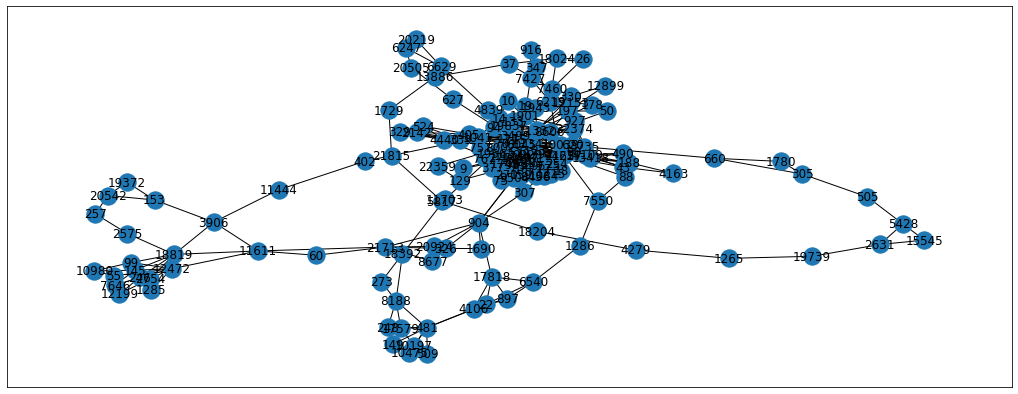

In [51]:
# Display a subgraph of 150 nodes related to Justin Trudeau.
justinTrudeauId = 11611
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, justinTrudeauId))[:150] 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos)

In [ ]:
# Perform random walks and then train the Word2Vec model.
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)
model = Word2Vec(walker.walks, hs=1, sg = 1, vector_size=128, window=10, min_count=1, workers=4)
model.wv.save_word2vec_format('facebook.bin', binary=True)

In [52]:
# Load the previously trained model
model = KeyedVectors.load_word2vec_format('models/facebook.bin', binary=True)

Let's find Facebook pages that are similar to Statistics Canada (ID: 12646)

In [53]:
statsCanId = '12646'
similarList =  model.most_similar(statsCanId)
targets.loc[[int(statsCanId)] + [int(i[0]) for i in similarList], :]

,id,facebook_id,page_name,page_type
id,,,,
12646,12646,125909694187216,Statistics Canada,government
8068,8068,181477762000062,Department of Justice Canada,government
3918,3918,209857686718,Healthy Canadians,government
9229,9229,502566449790031,Leaders Today,government
7648,7648,192657607776229,Clerk of the Privy Council,government
1368,1368,218581684934651,GovCan - Indigenous Peoples,government
20470,20470,401846167974,Transport and Infrastructure in Canada,government
11016,11016,318424514044,Environment and Natural Resources in Canada,government
22076,22076,461055440583693,Canada's 150th Anniversary of Confederation,government


How about Justin Trudeau? (ID: 11611)

In [55]:
justinTrudeauId = 11611
similarList =  model.most_similar(justinTrudeauId)
targets.loc[[justinTrudeauId] + [int(i[0]) for i in model.most_similar(similarList)], :]

,id,facebook_id,page_name,page_type
id,,,,
11611,11611,21751825648,Justin Trudeau,politician
7090,7090,188474554625330,Anne Minh Thu Quach,politician
18483,18483,195399673828162,Hoang Mai,politician
2089,2089,7711496179,Irene Mathyssen,politician
18353,18353,35693908458,Malcolm Allen,politician
20522,20522,273781809343070,Jasbir Sandhu,politician
302,302,113413235475306,Murray Rankin,politician
3993,3993,149331805154700,Tom Mulcair,politician
13750,13750,186856648056251,Niki Ashton,politician


It seems like nodes are neighboring very related Facebook pages and that it's working. We can now use them as a classifier for machine learning. We're going to see if we can predict the type of page (government, tvshow, company, etc) given the graph embedding.

In [56]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'page_type']

# Get corresponding embeddings
X_dw = []
for i in y.index:
    X_dw.append(model.__getitem__(str(i)))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))

0.9336893635959056


As you can see, the performance is really good with F1 score of approximately 0.93.